# Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import datetime
from datetime import datetime
import nbformat
from itertools import product
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Download dataset

In [ ]:
sales = pd.read_csv("./competitive-data-science-predict-future-sales/sales_train.csv")
items = pd.read_csv("./competitive-data-science-predict-future-sales/items.csv")
categories = pd.read_csv("./competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("./competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("./competitive-data-science-predict-future-sales/test.csv")

# Sales:

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_price - current price of an item

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

# Items:

item_name - name of item

item_id - unique identifier of a product

item_category_id - unique identifier of item category

# Categories:

item_category_name - name of item category

item_category_id


# Shops:

shop_name - name of shop

shop_id - unique identifier of a shop

In [ ]:
cat_graph=categories.copy(deep=True)
cat_graph['item_category']=cat_graph['item_category_name'].str.split('-')
cat_graph['category']=cat_graph['item_category'].apply(lambda x: x[0].strip())
cat_graph['item'] = cat_graph['item_category'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cat_graph.drop(['item_category_name','item_category'], inplace=True, axis=1)

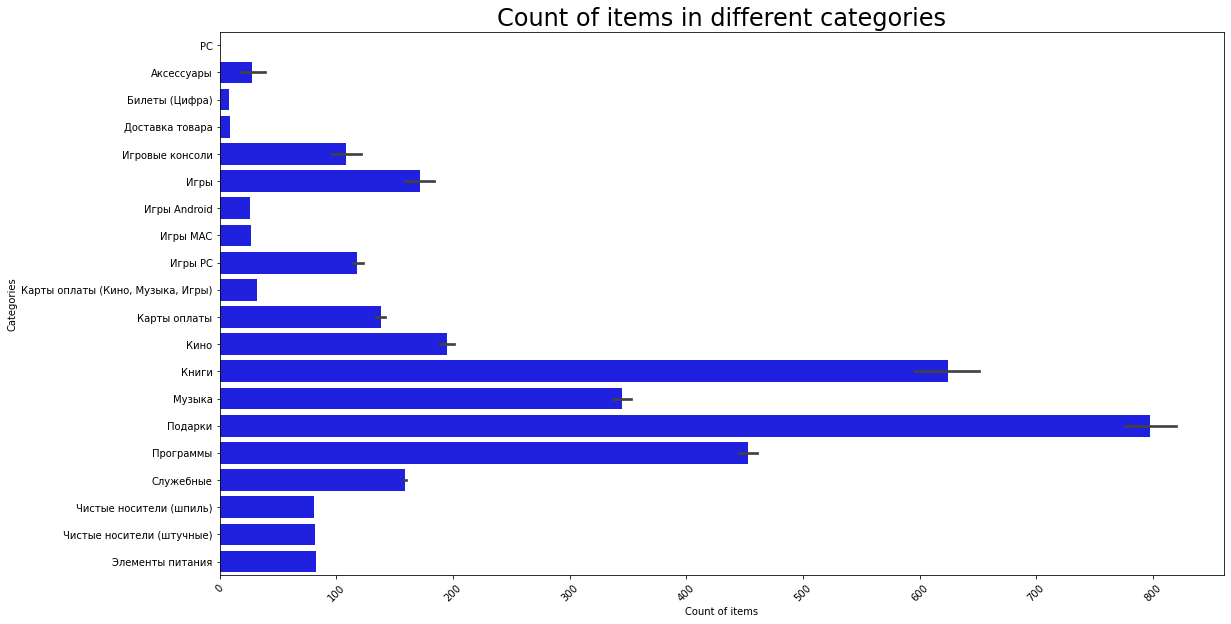

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Count of items in different categories', fontsize=24)
ax = sns.barplot(x='item_category_id', y='category', data=cat_graph, estimator=np.sum, color='b')
ax = ax.set(xlabel='Count of items', ylabel='Categories')
plt.xticks(rotation=45)
plt.show() 

# To merge datasets

In [ ]:
train = pd.merge(sales,
                    items[["item_id", "item_category_id"]],
                    how="inner",
                    on="item_id")

train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

test = pd.merge(test,
                   items[["item_id", "item_category_id"]],
                   how="inner",
                   on="item_id")

test["date_block_num"] = 34

In [ ]:
train

date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-02               0       59    22154       999.0   
1       2013-01-23               0       24    22154       999.0   
2       2013-01-20               0       27    22154       999.0   
3       2013-01-02               0       25    22154       999.0   
4       2013-01-03               0       25    22154       999.0   
...            ...             ...      ...      ...         ...   
2935844 2015-10-17              33       25     8428       249.0   
2935845 2015-10-01              33       25     7903     12198.0   
2935846 2015-10-29              33       25     7610      2890.0   
2935847 2015-10-22              33       25     7635      2100.0   
2935848 2015-10-01              33       25     7640      4040.0   

         item_cnt_day  item_category_id  
0                 1.0                37  
1                 1.0                37  
2                 1.0                37  
3                 1.0                37  
4                 1.0                37  
...               ...               ...  
2935844           1.0                40  
2935845           1.0                15  
2935846           1.0                64  
2935847           1.0                64  
2935848           1.0                64  

[2935849 rows x 7 columns]

In [ ]:
test

ID  shop_id  item_id  item_category_id  date_block_num
0            0        5     5037                19              34
1         5100        4     5037                19              34
2        10200        6     5037                19              34
3        15300        3     5037                19              34
4        20400        2     5037                19              34
...        ...      ...      ...               ...             ...
214195  193799       46      969                37              34
214196  198899       41      969                37              34
214197  203999       44      969                37              34
214198  209099       39      969                37              34
214199  214199       45      969                37              34

[214200 rows x 5 columns]

In [ ]:
train.describe().T

count          mean          std     min     25%  \
date_block_num    2880104.0     14.543161     9.431290     0.0     6.0   
shop_id           2880104.0     33.023105    16.230101     0.0    22.0   
item_id           2880104.0  10175.763193  6326.815360     0.0  4421.0   
item_price        2880104.0    752.877268   809.863463    -1.0   249.0   
item_cnt_day      2880104.0      1.128731     0.493832   -22.0     1.0   
item_category_id  2880104.0     40.168109    16.894474     0.0    29.0   
is_outlier        2880104.0      0.000000     0.000000     0.0     0.0   
year              2880104.0   2013.775810     0.768931  2013.0  2013.0   
month             2880104.0      6.233439     3.532758     1.0     3.0   

                     50%       75%      max  
date_block_num      14.0     23.00     33.0  
shop_id             31.0     47.00     59.0  
item_id           9280.0  15703.00  22169.0  
item_price         399.0    995.57   5999.0  
item_cnt_day         1.0      1.00      5.0  
item_category_id    40.0     55.00     83.0  
is_outlier           0.0      0.00      0.0  
year              2014.0   2014.00   2015.0  
month                6.0      9.00     12.0

min value of item_price = -1. It means that some product was returned. The same situation with item_cnt_day, namely 22 items were returned one day.

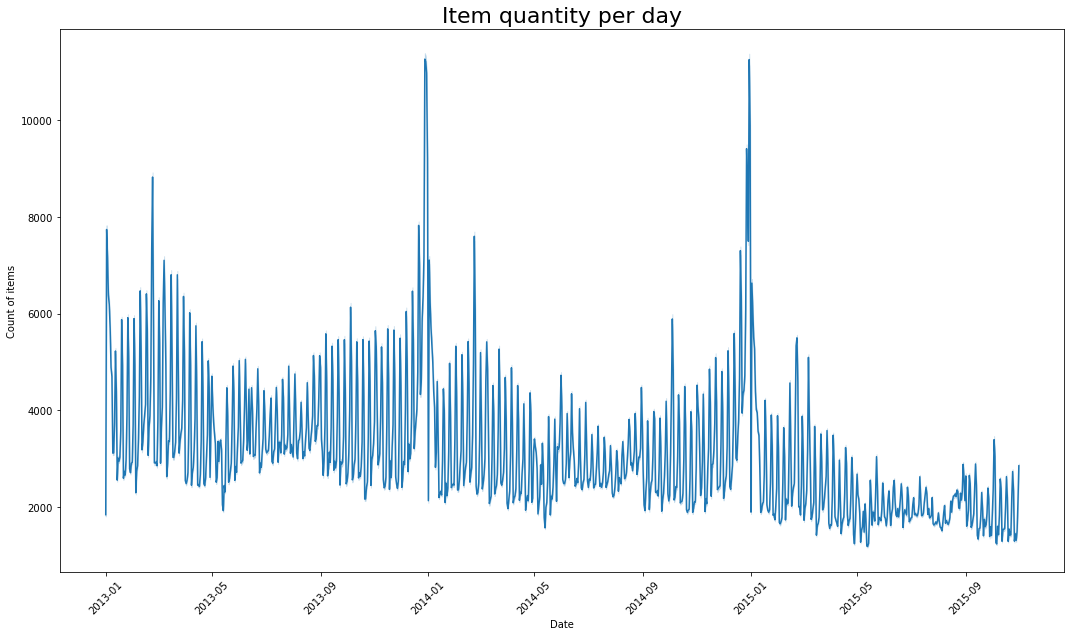

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per day', fontsize=22)
ax = sns.lineplot(x='date', y="item_cnt_day", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

Seems that there is some seasonality pattern.

In [ ]:
train["year"] = train.date.dt.year
train["month"] = train.date.dt.month

<ipython-input-24-cb7b4ae49f14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["year"] = train.date.dt.year
<ipython-input-24-cb7b4ae49f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["month"] = train.date.dt.month


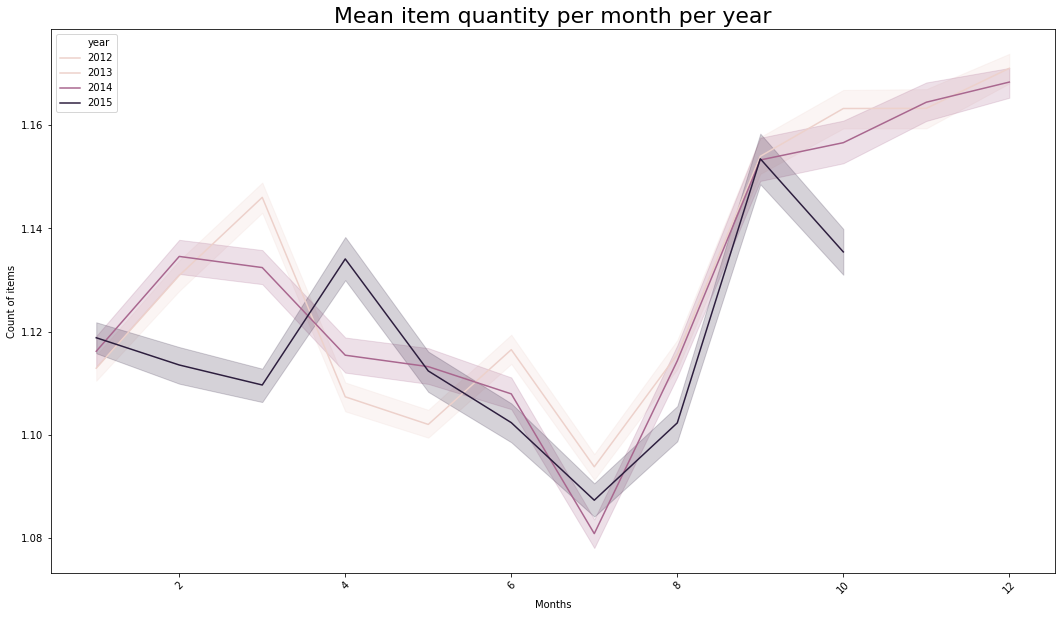

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Mean item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.mean)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()


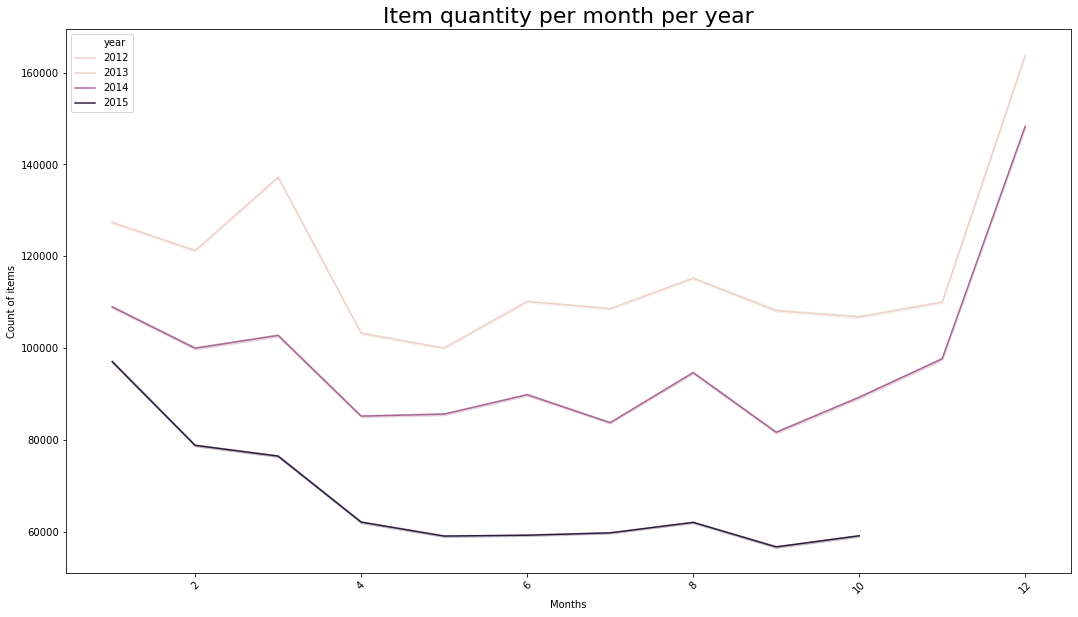

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per month per year', fontsize=22)
ax = sns.lineplot(x='month', y="item_cnt_day", hue="year", data=train, estimator=np.sum)
ax = ax.set(xlabel='Months', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

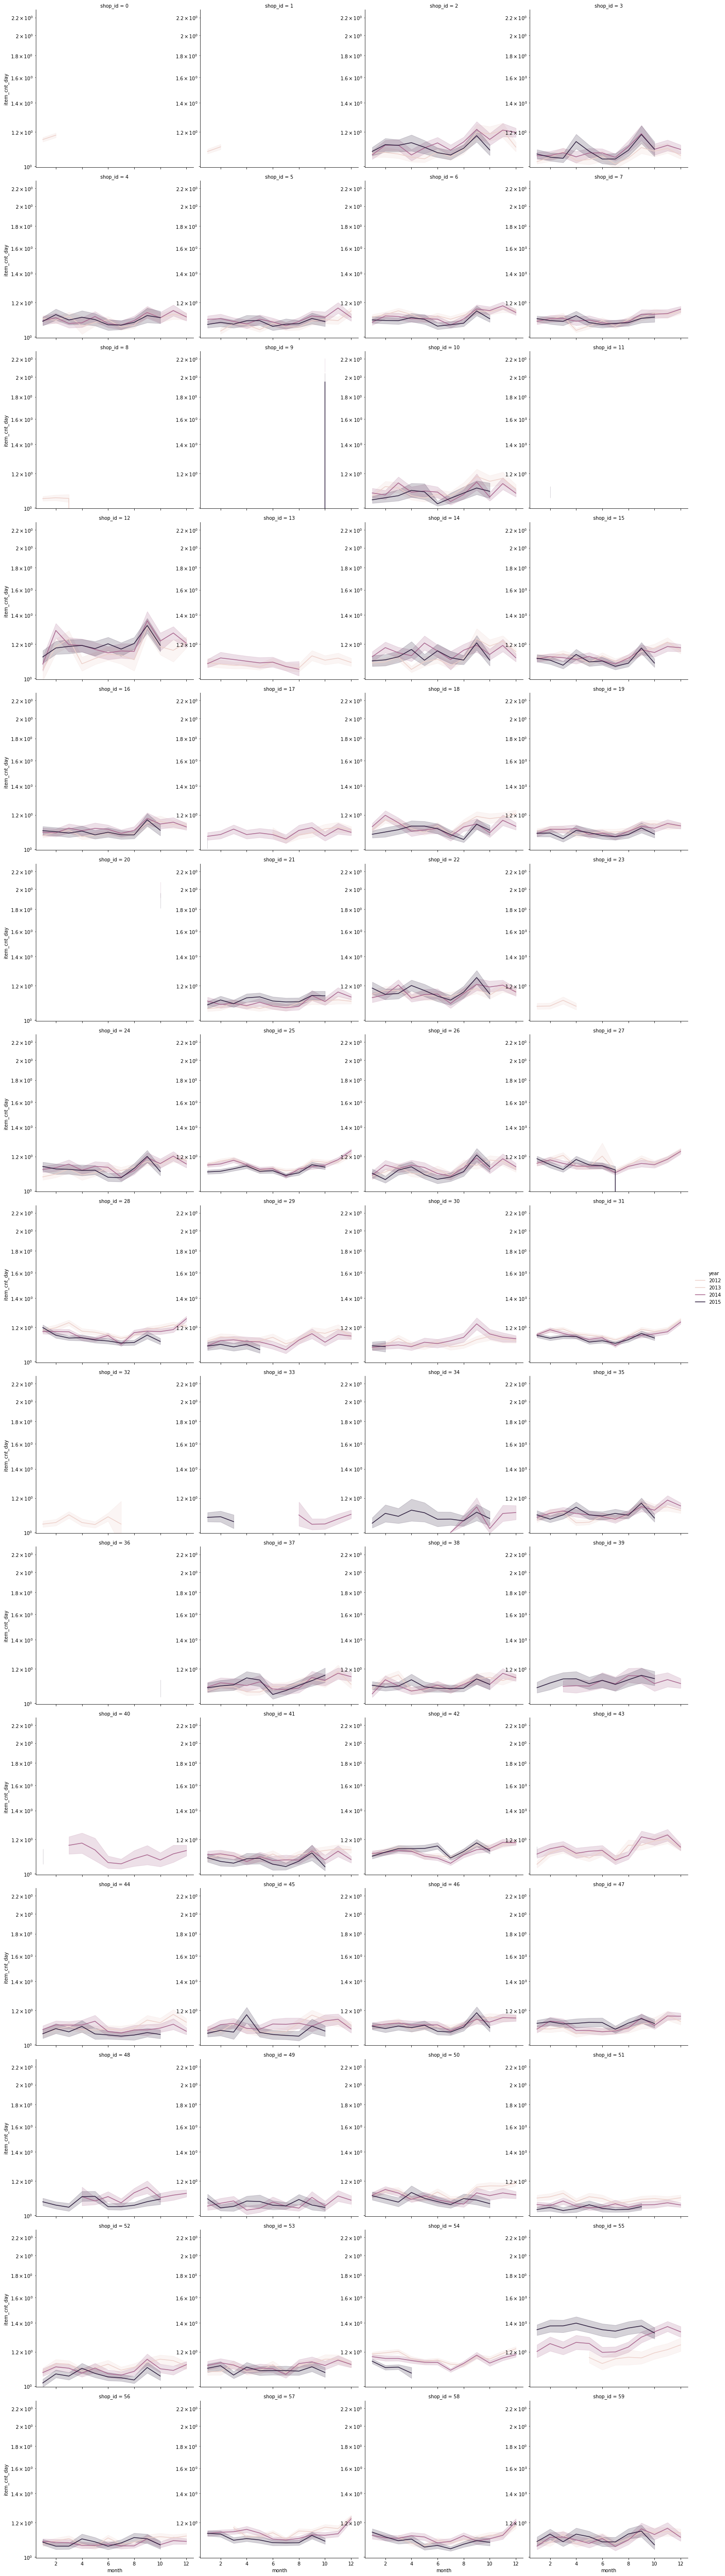

In [ ]:
# Mean Item Quantity Per Month Per Year

g = sns.relplot(x="month",
                y="item_cnt_day",
                kind="line",
                hue="year",
                col="shop_id",
                col_wrap=4,
                data=train,
                estimator="mean")

plt.yscale("log")

Some shops don't have sales for all months. This can be a problem if there is there is such store on the test set. Let's check that.

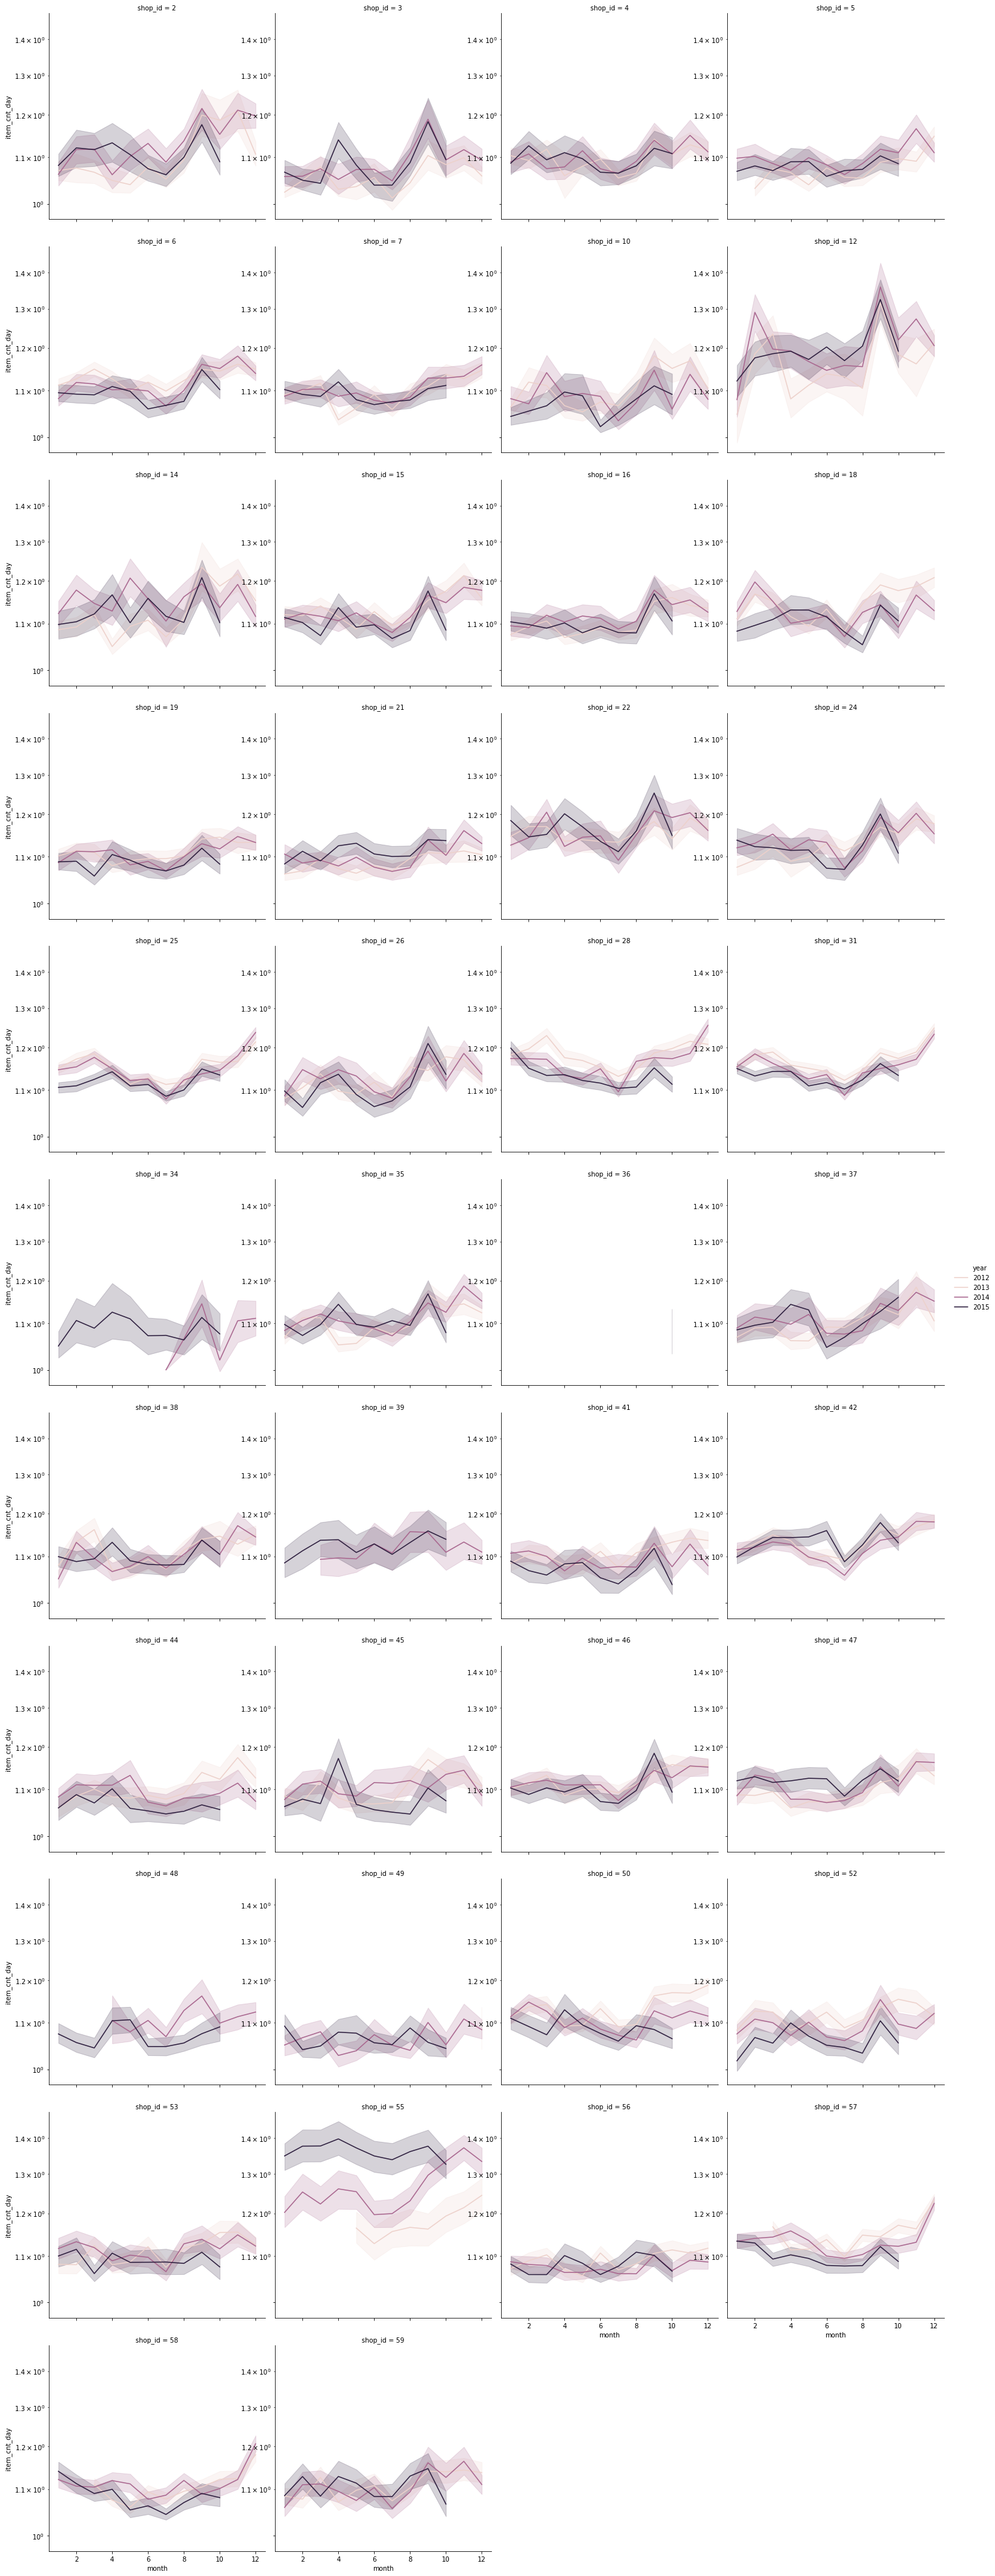

In [ ]:
test_shops = test.shop_id.unique()

g = sns.relplot(x="month",
                y="item_cnt_day",
                kind="line",
                hue="year",
                col="shop_id",
                col_wrap=4,
                data=train[(train.shop_id.isin(test_shops))],
                estimator="mean")

plt.yscale("log")

So shop_id = 36 need some imputation maybe.

In [ ]:
monthly = train \
    .groupby(["year", "month", "date_block_num", 
              "shop_id", "item_category_id", "item_id"])\
    .agg({"item_price":["mean"],
          "item_cnt_day":["sum"]})

monthly.columns = ["_".join(x) for x in monthly.columns.ravel()]
monthly.reset_index(drop=False, inplace=True)

monthly["log_price"] = np.log(monthly.item_price_mean)

monthly.head()

year  month  date_block_num  shop_id  item_category_id  item_id  \
0  2013      1               0        0                 2     5572   
1  2013      1               0        0                 2     5573   
2  2013      1               0        0                 2     5575   
3  2013      1               0        0                 2     5576   
4  2013      1               0        0                 2     5609   

   item_price_mean  item_cnt_day_sum  log_price  
0           1322.0              10.0   7.186901  
1            560.0               1.0   6.327937  
2            806.0               4.0   6.692084  
3           2231.0               5.0   7.710205  
4           2381.0               1.0   7.775276

In [ ]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [ ]:
monthly = monthly[monthly.item_cnt_day_sum>0]

In [ ]:
first_date = datetime.datetime.strptime("2013-01-01 00:00:00",
                                        "%Y-%m-%d %H:%M:%S")
dates = []
blocks = list(range(35))
for block in blocks:
    dates.append(first_date + relativedelta(months=block))

block_dates = pd.DataFrame({"date_block_num":blocks, "date":dates})

In [ ]:

index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in monthly['date_block_num'].unique():
    cur_shops = monthly[monthly['date_block_num']==block_num]['shop_id'].unique()
    cur_items = monthly[monthly['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = monthly.groupby(index_cols,as_index=False).agg({'item_cnt_day_sum':'sum'})

#fix column names
gb.rename({"item_cnt_day_sum":"target"}, inplace=True, axis=1)

#join aggregated data to the grid
monthly_graph = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
monthly_graph.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

# Merge dates for each block
monthly_graph = monthly_graph.merge(block_dates, on="date_block_num", how="left")

# Create ID to use with feature tools relationship
monthly_graph["super_id"] = \
    monthly_graph.shop_id.map(str) + "," + \
    monthly_graph.item_id.map(str) 
monthly_graph = downcast_dtypes(monthly_graph)
print(monthly_graph.info())
monthly_graph.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10786249 entries, 0 to 10786248
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   shop_id         int32         
 1   item_id         int32         
 2   date_block_num  int32         
 3   target          float32       
 4   date            datetime64[ns]
 5   super_id        object        
dtypes: datetime64[ns](1), float32(1), int32(3), object(1)
memory usage: 411.5+ MB
None


shop_id  item_id  date_block_num  target       date super_id
0        0       19               0     0.0 2013-01-01     0,19
1        0       27               0     0.0 2013-01-01     0,27
2        0       28               0     0.0 2013-01-01     0,28
3        0       29               0     0.0 2013-01-01     0,29
4        0       32               0     6.0 2013-01-01     0,32

In [ ]:
#monthly['date']=pd.to_datetime(monthly.apply(lambda x: f"{x['year']}-{x['month']}", axis=1))

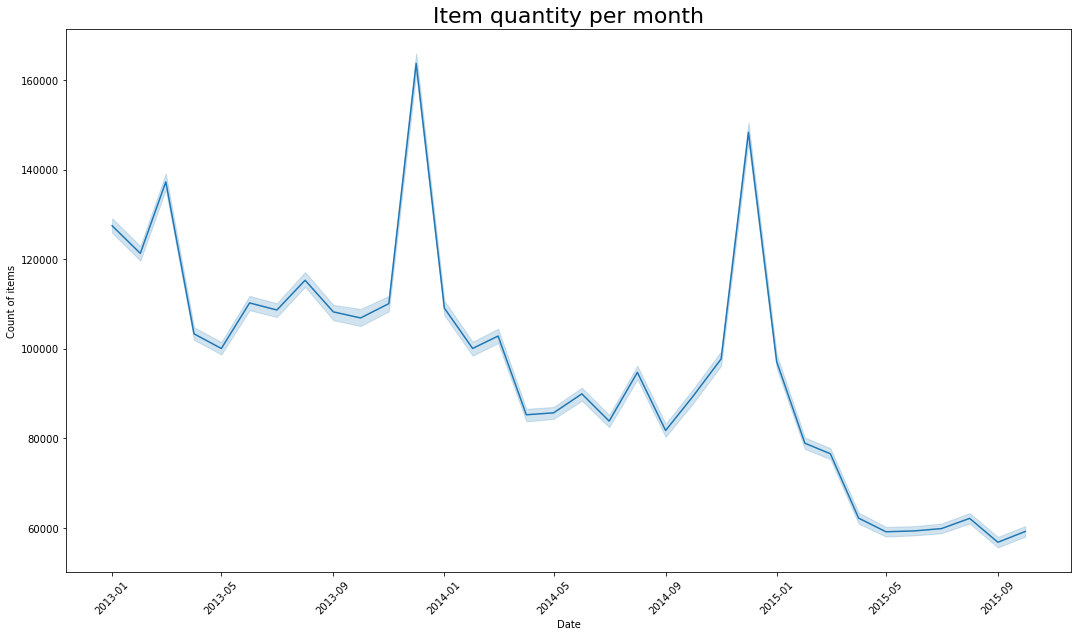

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Item quantity per month', fontsize=22)
ax = sns.lineplot(x='date', y="target", data=monthly_graph, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items')
plt.xticks(rotation=45)
plt.show()

In [ ]:
ex_one=pd.DataFrame(monthly_graph.loc[monthly_graph['super_id'] == '2,7894'])
ex_two=pd.DataFrame(monthly_graph.loc[monthly_graph['super_id'] == '2,7893'])
ex_three=pd.DataFrame(monthly_graph.loc[monthly_graph['super_id'] == '18,7894'])
ex_four=pd.DataFrame(monthly_graph.loc[monthly_graph['super_id'] == '2,13511'])
ex_five=pd.DataFrame(monthly_graph.loc[monthly_graph['super_id'] == '28,5643'])

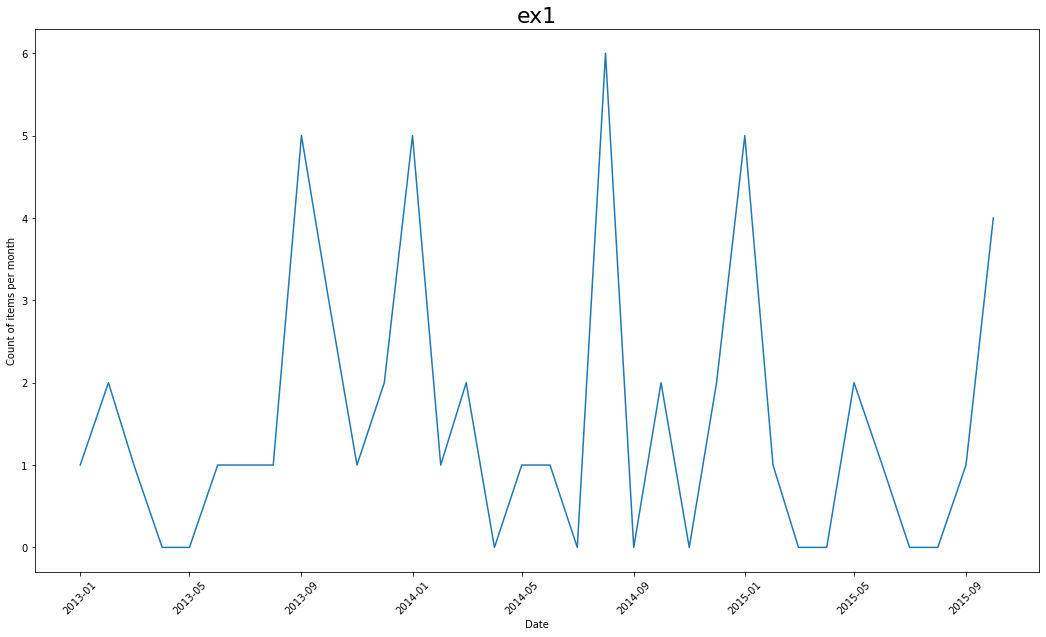

In [ ]:
plt.figure(figsize = (18,10))
plt.title('ex1', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=ex_one)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

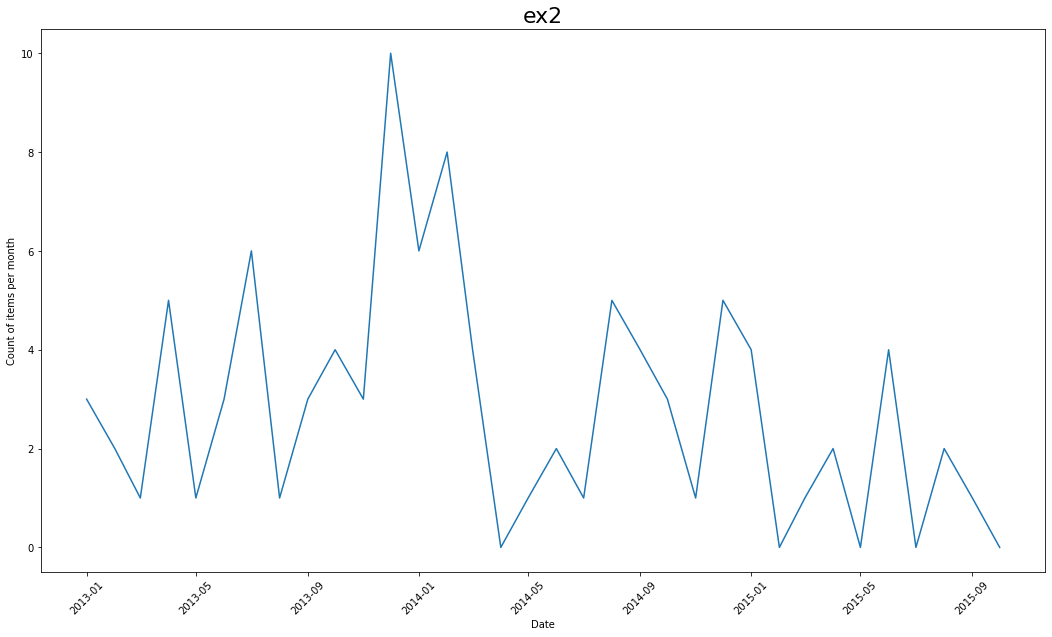

In [ ]:
plt.figure(figsize = (18,10))
plt.title('ex2', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=ex_two)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

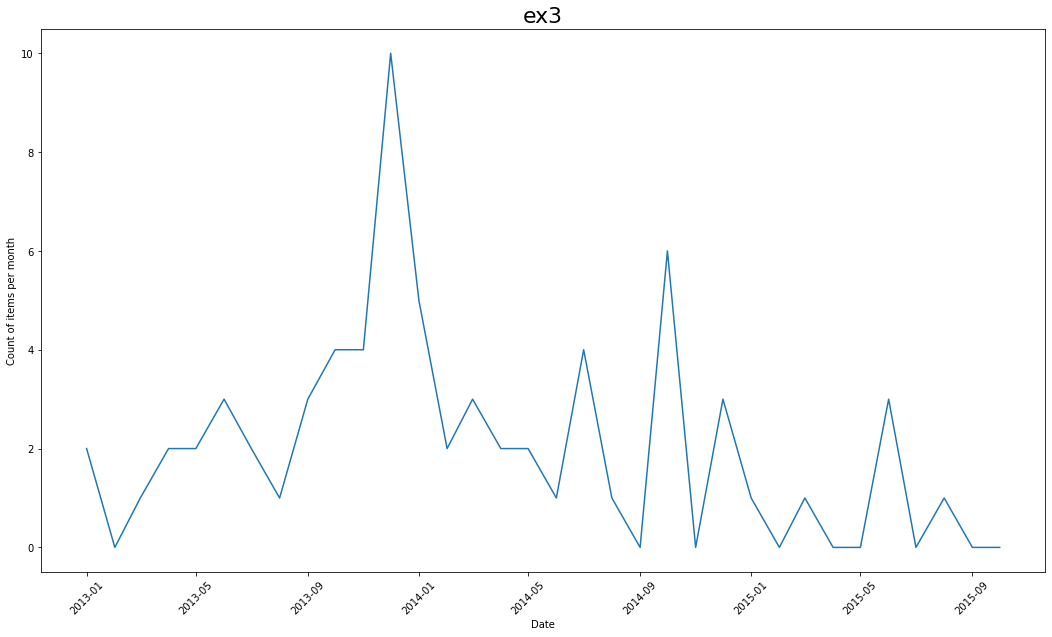

In [ ]:
plt.figure(figsize = (18,10))
plt.title('ex3', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=ex_three)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

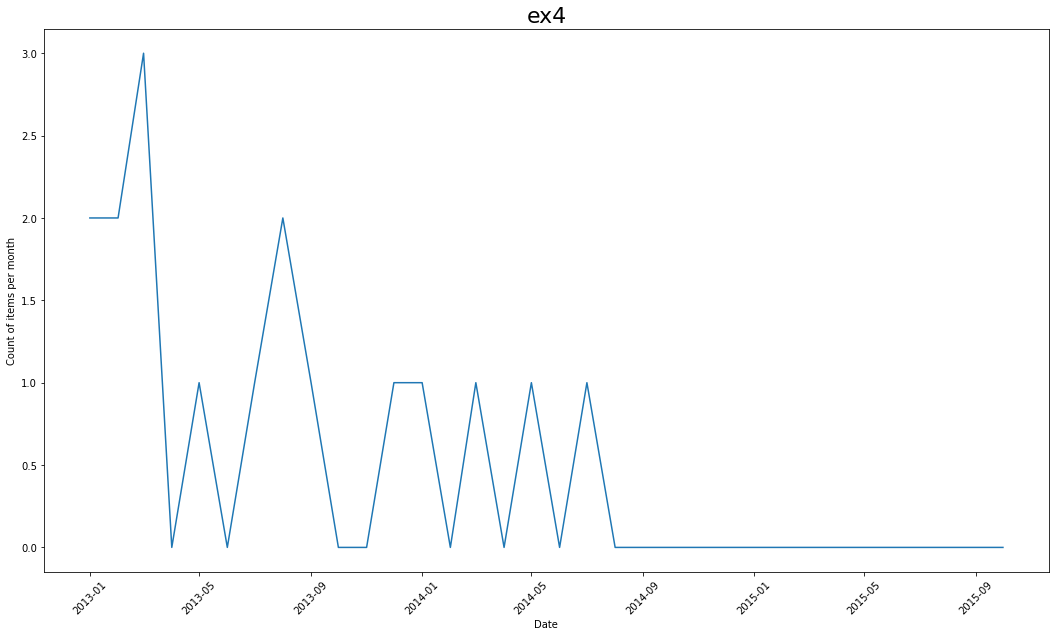

In [ ]:
plt.figure(figsize = (18,10))
plt.title('ex4', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=ex_four)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

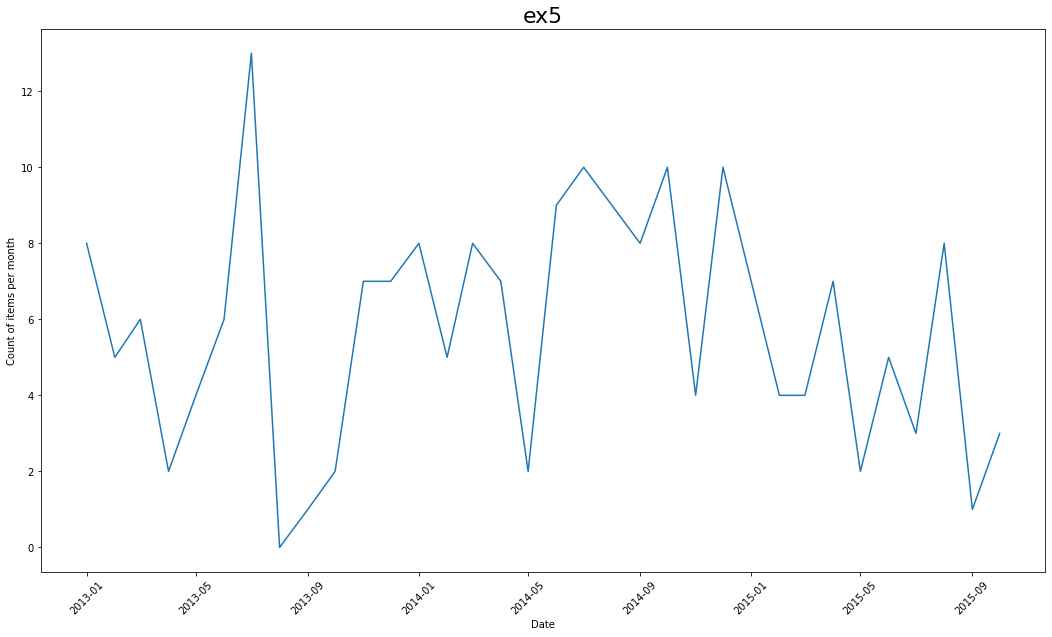

In [ ]:
plt.figure(figsize = (18,10))
plt.title('ex5', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=ex_five)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
second_shop=pd.DataFrame(monthly_graph.loc[monthly_graph['shop_id'] == 2])
third_shop=pd.DataFrame(monthly_graph.loc[monthly_graph['shop_id'] == 3])
forth_shop=pd.DataFrame(monthly_graph.loc[monthly_graph['shop_id'] == 4])
fifth_shop=pd.DataFrame(monthly_graph.loc[monthly_graph['shop_id'] == 5])
sixth_shop=pd.DataFrame(monthly_graph.loc[monthly_graph['shop_id'] == 6])

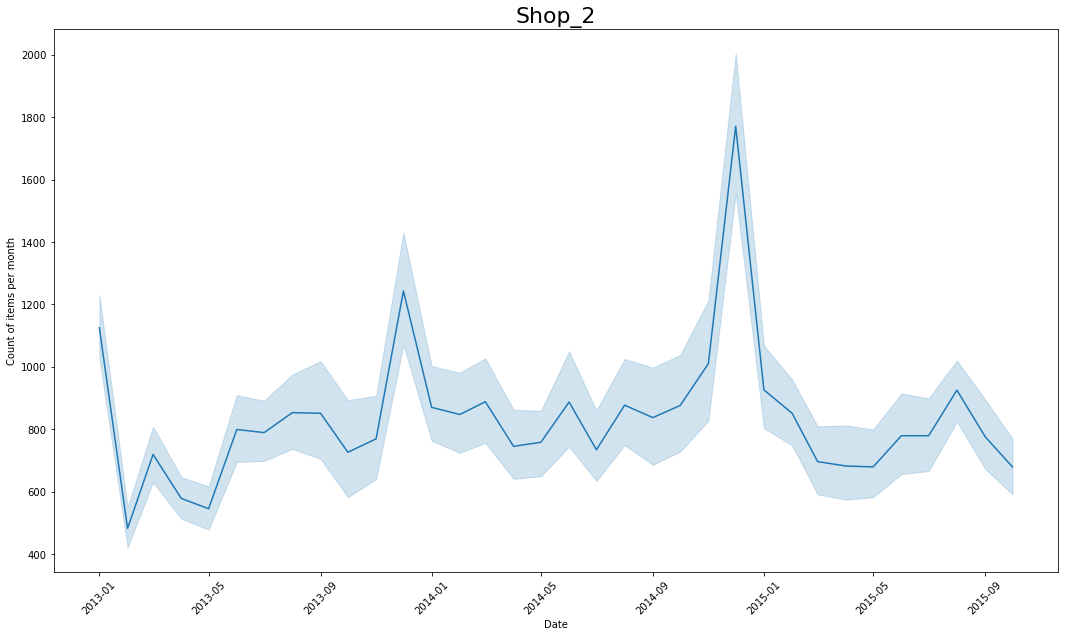

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_2', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=second_shop, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

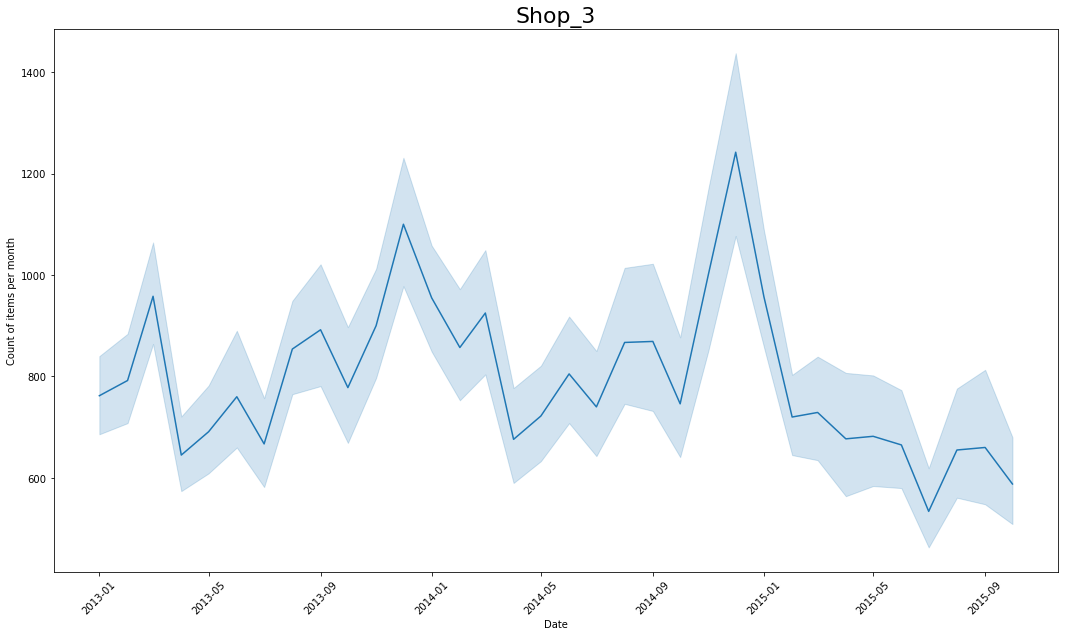

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_3', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=third_shop, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

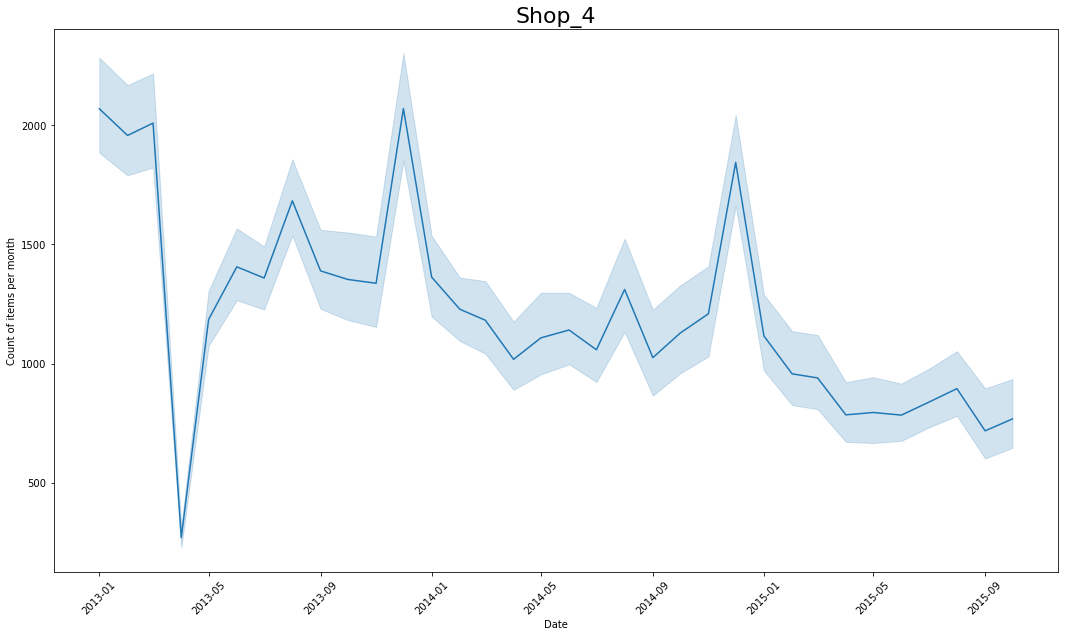

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_4', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=forth_shop, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

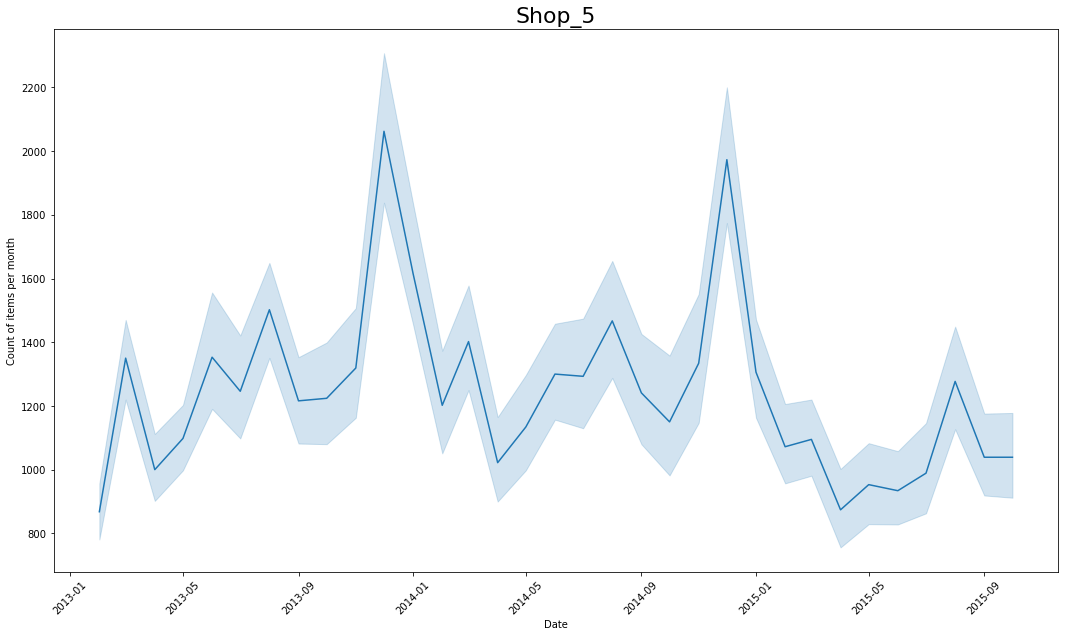

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_5', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=fifth_shop, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

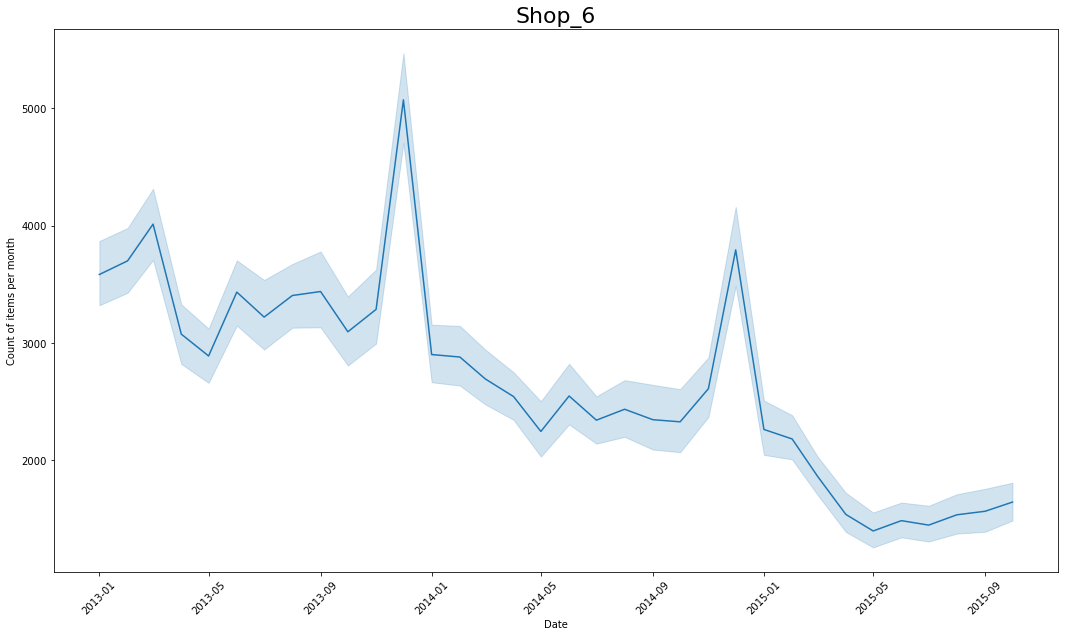

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Shop_6', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=sixth_shop, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
monthly

year  month  date_block_num  shop_id  item_category_id  item_id  \
0        2013      1               0        0                 2     5572   
1        2013      1               0        0                 2     5573   
2        2013      1               0        0                 2     5575   
3        2013      1               0        0                 2     5576   
4        2013      1               0        0                 2     5609   
...       ...    ...             ...      ...               ...      ...   
1593721  2015     10              33       59                75     5383   
1593722  2015     10              33       59                79    17717   
1593723  2015     10              33       59                83    22087   
1593724  2015     10              33       59                83    22088   
1593725  2015     10              33       59                83    22091   

         item_price_mean  item_cnt_day_sum  log_price  
0                1322.00              10.0   7.186901  
1                 560.00               1.0   6.327937  
2                 806.00               4.0   6.692084  
3                2231.00               5.0   7.710205  
4                2381.00               1.0   7.775276  
...                  ...               ...        ...  
1593721          4390.00               1.0   8.387085  
1593722           802.55              13.0   6.687794  
1593723           119.00               6.0   4.779123  
1593724           119.00               2.0   4.779123  
1593725           179.00               1.0   5.187386  

[1590348 rows x 9 columns]

In [ ]:
index_cols = ['shop_id', 'date_block_num']


# For every month we create a grid from all shops combinations from that month
grid = [] 
for block_num in monthly['date_block_num'].unique():
    cur_shops = monthly[monthly['date_block_num']==block_num]['shop_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, month)
gb = monthly.groupby(index_cols,as_index=False).agg({'item_cnt_day_sum':'sum','item_price_mean':'sum'})

#fix column names
gb.rename({"item_cnt_day_sum":"target", 'item_price_mean':'item_price_sum'}, inplace=True, axis=1)

#join aggregated data to the grid
train_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
train_data.sort_values(['date_block_num','shop_id'],inplace=True)

# Merge dates for each block
train_data = train_data.merge(block_dates, on="date_block_num", how="left")

train_data = downcast_dtypes(train_data)
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582 entries, 0 to 1581
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   shop_id         1582 non-null   int32         
 1   date_block_num  1582 non-null   int32         
 2   target          1582 non-null   float32       
 3   item_price_sum  1582 non-null   float32       
 4   date            1582 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(2)
memory usage: 49.4 KB
None


shop_id  date_block_num  target  item_price_sum       date
0        0               0  5464.0    874023.37500 2013-01-01
1        1               0  2887.0    573443.31250 2013-01-01
2        2               0  1125.0    481489.12500 2013-01-01
3        3               0   762.0    356334.84375 2013-01-01
4        4               0  2069.0    602085.18750 2013-01-01

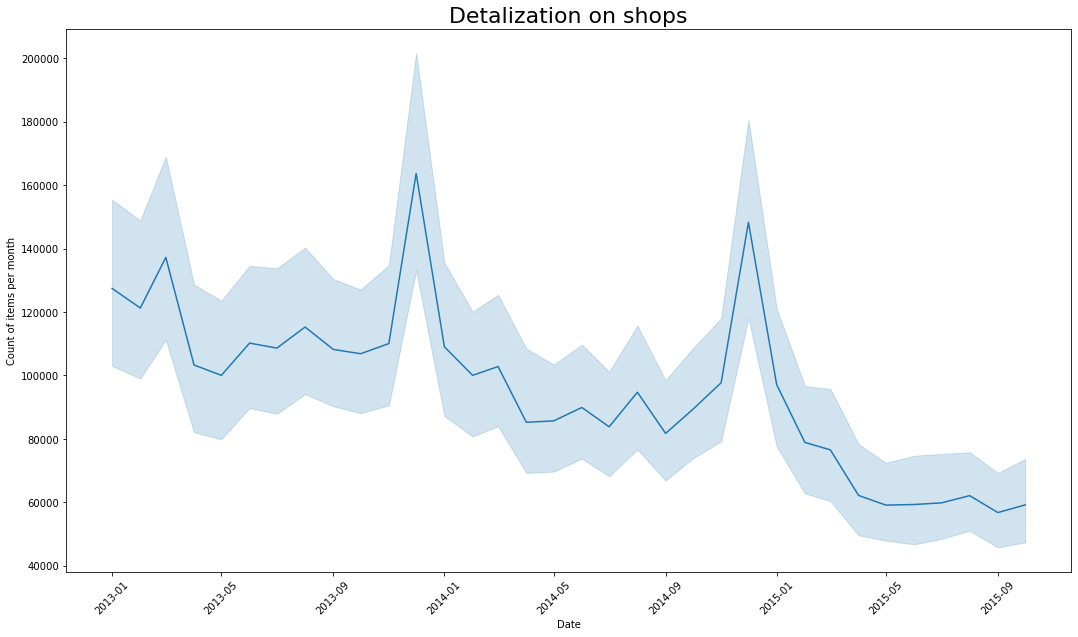

In [ ]:
plt.figure(figsize = (18,10))
plt.title('Detalization on shops', fontsize=22)
ax = sns.lineplot(x='date', y='target', data=train_data, estimator=np.sum)
ax = ax.set(xlabel='Date', ylabel='Count of items per month')
plt.xticks(rotation=45)
plt.show() 

In [ ]:
train_data

shop_id  date_block_num  target  item_price_sum       date
0           0               0  5464.0    874023.37500 2013-01-01
1           1               0  2887.0    573443.31250 2013-01-01
2           2               0  1125.0    481489.12500 2013-01-01
3           3               0   762.0    356334.84375 2013-01-01
4           4               0  2069.0    602085.18750 2013-01-01
...       ...             ...     ...             ...        ...
1577       55              33  1788.0    262270.21875 2015-10-01
1578       56              33  1225.0    662859.18750 2015-10-01
1579       57              33  2245.0    987888.31250 2015-10-01
1580       58              33  1415.0    703496.25000 2015-10-01
1581       59              33   767.0    447267.18750 2015-10-01

[1582 rows x 5 columns]

In [ ]:
test["date_block_num"]=34
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   ID                214200 non-null  int64
 1   shop_id           214200 non-null  int64
 2   item_id           214200 non-null  int64
 3   item_category_id  214200 non-null  int64
 4   date_block_num    214200 non-null  int64
dtypes: int64(5)
memory usage: 9.8 MB
None


ID  shop_id  item_id  item_category_id  date_block_num
0      0        5     5037                19              34
1   5100        4     5037                19              34
2  10200        6     5037                19              34
3  15300        3     5037                19              34
4  20400        2     5037                19              34

# Test / Validation Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2015-may
train_1 = get_index(0, 28, train_data, "date_block_num")

# 2013-jun
val_1 = get_index(29, 29, train_data, "date_block_num")

# 2013-jan >> 2015-jun
train_2 = get_index(0, 29, train_data, "date_block_num")

# 2014-jul
val_2 = get_index(30, 30, train_data, "date_block_num")

# 2013-jan >> 2015-jul
train_3 = get_index(0, 30, train_data, "date_block_num")

# 2015-aug
val_3 = get_index(31, 31, train_data, "date_block_num")

# 2013-jan >> 2015-aug
train_4 = get_index(0, 31, train_data, "date_block_num")

# 2015-sep
val_4 = get_index(32, 32, train_data, "date_block_num")

# 2013-jan >> 2015-sep
train_5 = get_index(0, 32, train_data, "date_block_num")

# 2015-oct
val_5 = get_index(33, 33, train_data, "date_block_num")


folds = [(train_1, val_1), (train_2, val_2), (train_3, val_3), (train_4, val_4), (train_5, val_5)]

In [ ]:
folds

[(array([   0,    1,    2, ..., 1365, 1366, 1367], dtype=int64),
  array([1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378,
         1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389,
         1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400,
         1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410],
        dtype=int64)),
 (array([   0,    1,    2, ..., 1408, 1409, 1410], dtype=int64),
  array([1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421,
         1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432,
         1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443,
         1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453],
        dtype=int64)),
 (array([   0,    1,    2, ..., 1451, 1452, 1453], dtype=int64),
  array([1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464,
         1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475,
         1476, 1477

In [ ]:
folds[0][0].shape

(1368,)

In [ ]:
remove_cols = ["target", "date"]
features = [col for col in train_data.columns if col not in remove_cols]
target="target"
print(features)
print(target)

['shop_id', 'date_block_num', 'item_price_sum']
target


In [ ]:
#Fold-1
X_train_1 = train_data.loc[train_1, features]
X_val_1 = train_data.loc[val_1, features]
y_train_1 = train_data.loc[train_1, target]
y_val_1 = train_data.loc[val_1, target]
#Fold-2
X_train_2 = train_data.loc[train_2, features]
X_val_2 = train_data.loc[val_2, features]
y_train_2 = train_data.loc[train_2, target]
y_val_2 = train_data.loc[val_2, target]
#Fold-3
X_train_3 = train_data.loc[train_3, features]
X_val_3 = train_data.loc[val_3, features]
y_train_3 = train_data.loc[train_3, target]
y_val_3 = train_data.loc[val_3, target]
#Fold-4
X_train_4 = train_data.loc[train_4, features]
X_val_4 = train_data.loc[val_4, features]
y_train_4 = train_data.loc[train_4, target]
y_val_4 = train_data.loc[val_4, target]
#Fold-5
X_train_5 = train_data.loc[train_5, features]
X_val_5 = train_data.loc[val_5, features]
y_train_5 = train_data.loc[train_5, target]
y_val_5 = train_data.loc[val_5, target]

# Model 0

In [ ]:
def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2015-may
train_1_0 = get_index(0, 29, train_data, "date_block_num")

# 2013-jun
val_1_0 = get_index(29, 29, train_data, "date_block_num")

# 2013-jan >> 2015-jun
train_2_0 = get_index(0, 30, train_data, "date_block_num")

# 2014-jul
val_2_0 = get_index(30, 30, train_data, "date_block_num")

# 2013-jan >> 2015-jul
train_3_0 = get_index(0, 31, train_data, "date_block_num")

# 2015-aug
val_3_0 = get_index(31, 31, train_data, "date_block_num")

# 2013-jan >> 2015-aug
train_4_0 = get_index(0, 32, train_data, "date_block_num")

# 2015-sep
val_4_0 = get_index(32, 32, train_data, "date_block_num")

# 2013-jan >> 2015-sep
train_5_0 = get_index(0, 33, train_data, "date_block_num")

# 2015-oct
val_5_0 = get_index(33, 33, train_data, "date_block_num")


folds_0 = [(train_1_0, val_1_0), (train_2_0, val_2_0), (train_3_0, val_3_0), (train_4_0, val_4_0), (train_5_0, val_5_0)]

In [ ]:
#Fold-1
X_train_1_0 = train_data.loc[train_1_0, features]
X_val_1_0 = train_data.loc[val_1_0, features]
y_train_1_0 = train_data.loc[train_1_0, target]
y_val_1_0 = train_data.loc[val_1_0, target]
#Fold-2
X_train_2_0 = train_data.loc[train_2_0, features]
X_val_2_0 = train_data.loc[val_2_0, features]
y_train_2_0 = train_data.loc[train_2_0, target]
y_val_2_0 = train_data.loc[val_2_0, target]
#Fold-3
X_train_3_0 = train_data.loc[train_3_0, features]
X_val_3_0 = train_data.loc[val_3_0, features]
y_train_3_0 = train_data.loc[train_3_0, target]
y_val_3_0 = train_data.loc[val_3_0, target]
#Fold-4
X_train_4_0 = train_data.loc[train_4_0, features]
X_val_4_0 = train_data.loc[val_4_0, features]
y_train_4_0 = train_data.loc[train_4_0, target]
y_val_4_0 = train_data.loc[val_4_0, target]
#Fold-5
X_train_5_0 = train_data.loc[train_5_0, features]
X_val_5_0 = train_data.loc[val_5_0, features]
y_train_5_0 = train_data.loc[train_5_0, target]
y_val_5_0 = train_data.loc[val_5_0, target]

In [ ]:
X = y_train_1_0.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [ ]:
# walk-forward validation
history = [x for x in y_train_1_0]
predictions = list()
for i in range(len(y_val_1_0)):
    # predict
    yhat=history
    predictions.append(yhat)
    # observation
    obs = y_val_1_0[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mae = mean_absolute_error(y_val_1_0, predictions)

KeyError: 0

In [ ]:
mae

1.9534883720930232

# SimpleExpSmoothing

In [ ]:
def ses(train, val):
    fit = SimpleExpSmoothing(train).fit(smoothing_level = 0.6,optimized = False)
    pred = fit.forecast(len(val))
    mae = mean_absolute_error(val, pred)
    return mae

In [ ]:
mae_1=ses(y_train_1, y_val_1)
mae_2=ses(y_train_2, y_val_2)
mae_3=ses(y_train_3, y_val_3)
mae_4=ses(y_train_4, y_val_4)
mae_5=ses(y_train_5, y_val_5)
mae_ses=(mae_1+mae_2+mae_3+mae_4+mae_5)/5
mae_ses

595.2584271638497